In [1]:
# --- CELL 1: run OLD NumPy SWAMPE, save, and load final geopotential snapshot ---

import tempfile
from pathlib import Path

import numpy as np
import SWAMPE  # old/reference package

# parameters (match your examples)
a = 5.2e7
omega = 3.2e-5
Phibar = 4e6
dt = 30
tmax = 201
M = 42
DPhieq = Phibar
taurad = 3600 * 24
taudrag = 1 * 3600 * 24

# save into a temp directory (SWAMPE expects a trailing slash)
outdir = Path(tempfile.mkdtemp(prefix="swampe_ref_"))
custompath = str(outdir) + "/"

# run without plotting, but save frequently so we can reliably grab the final snapshot
SWAMPE.run_model(
    M, dt, tmax, Phibar, omega, a,
    taurad=taurad,
    taudrag=taudrag,
    DPhieq=DPhieq,
    plotflag=False,
    saveflag=True,
    savefreq=1,
    custompath=custompath,
    verbose=False,
    timeunits="seconds",
    expflag=False,
)

# find the latest saved Phi-* file and load fields
phi_files = sorted(outdir.glob("Phi-*"), key=lambda p: int(p.name.split("-")[1]))
if not phi_files:
    raise RuntimeError(f"No saved Phi-* files found in {outdir}.")
timestamp_sec = int(phi_files[-1].name.split("-")[1])  # e.g. 3000

Phi_old = SWAMPE.continuation.read_pickle(f"Phi-{timestamp_sec}", custompath=custompath)
U_old   = SWAMPE.continuation.read_pickle(f"U-{timestamp_sec}",   custompath=custompath)
V_old   = SWAMPE.continuation.read_pickle(f"V-{timestamp_sec}",   custompath=custompath)

# grid (old SWAMPE)
_, I, J, _, lambdas_old, mus_old, _ = SWAMPE.initial_conditions.spectral_params(M)

Phi_old = np.asarray(Phi_old) + Phibar  # legacy plotting convention
U_old = np.asarray(U_old)
V_old = np.asarray(V_old)
lambdas_old = np.asarray(lambdas_old)
mus_old = np.asarray(mus_old)

print(f"[OLD SWAMPE] final saved time = {timestamp_sec:.1f} s  (dir: {outdir})")


[OLD SWAMPE] final saved time = 6000.0 s  (dir: /var/folders/8_/lltwgz4x48ncx3q3k86fr_tm0000gq/T/swampe_ref_z2qxm4zp)


[JAX my_swamp] final time (last index) = 6000.0 s
[COMPARE] using time = 6000 s (OLD) vs 6000 s (JAX snapshot)
[COMPARE] max |fractional diff| = 4.657e-16


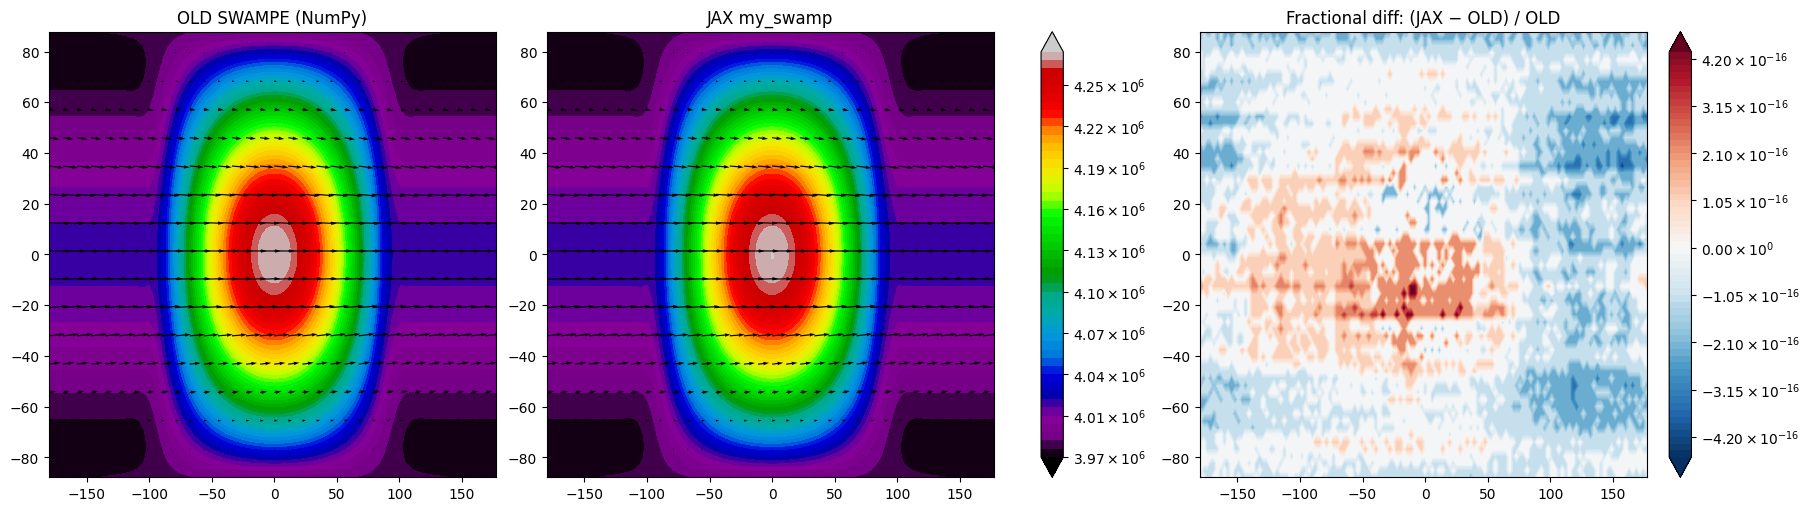

In [2]:
# --- CELL 2: run JAX my_swamp, then 3 panels: OLD, JAX, fractional diff ---

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as ticker

from my_swamp.model import run_model_scan

# parameters (must match Cell 1)
a = 5.2e7
omega = 3.2e-5
Phibar = 4e6
dt = 30
tmax = 201
M = 42
DPhieq = Phibar
taurad = 3600 * 24
taudrag = 1 * 3600 * 24

# --- run JAX scan ---
jax_res = run_model_scan(
    M=M,
    dt=dt,
    tmax=tmax,
    Phibar=Phibar,
    omega=omega,
    a=a,
    taurad=taurad,
    taudrag=taudrag,
    DPhieq=DPhieq,
    expflag=False,
    timeunits="seconds",
)

t_seq = np.asarray(jax_res["t_seq"]).astype(int)
t_final_jax_sec = float(t_seq[-1] * dt)

# pick the JAX snapshot at the same physical time as OLD SWAMPE if available, else last
target_sec = int(timestamp_sec)
sec_seq = t_seq * int(dt)
hits = np.where(sec_seq == target_sec)[0]
k = int(hits[-1]) if hits.size else (len(t_seq) - 1)
t_used_jax_sec = int(sec_seq[k])

Phi_jax = np.asarray(jax_res["outs"]["Phi"][k]) + Phibar
U_jax   = np.asarray(jax_res["outs"]["U"][k])
V_jax   = np.asarray(jax_res["outs"]["V"][k])

static = jax_res["static"]
lambdas_jax = np.asarray(static.lambdas)
mus_jax = np.asarray(static.mus)

print(f"[JAX my_swamp] final time (last index) = {t_final_jax_sec:.1f} s")
print(f"[COMPARE] using time = {target_sec} s (OLD) vs {t_used_jax_sec} s (JAX snapshot)")

# --- exact SWAMPE-style formatter ---
def _fmt_sci(x, _pos):
    a, b = f"{x:.2e}".split("e")
    return rf"${a} \times 10^{{{int(b)}}}$"

def swampe_quiver_geopot_ax(ax, U, V, Phi, lambdas, mus, timestamp_sec, *, minlevel=None, maxlevel=None, sparseness=4):
    X = lambdas * 180 / np.pi
    Y = np.arcsin(mus) * 180 / np.pi

    # first contourf call (as in SWAMPE)
    ax.contourf(X, Y, Phi)

    if minlevel is None:
        minlevel = float(np.min(Phi))
    if maxlevel is None:
        maxlevel = float(np.max(Phi))

    levels = np.linspace(minlevel, maxlevel)
    CS = ax.contourf(X, Y, Phi, levels=levels, cmap=cm.nipy_spectral, extend="both")

    # prevent aliasing artifacts (as in SWAMPE)
    for c in ax.collections:
        c.set_edgecolor("face")

    Xs = X[0::sparseness]
    Ys = Y[0::sparseness]
    Us = U[0::sparseness, 0::sparseness]
    Vs = V[0::sparseness, 0::sparseness]
    ax.quiver(Xs, Ys, Us, Vs)

    ax.set_title(f"Geopotential at {int(timestamp_sec)} seconds")
    return CS

# Use OLD SWAMPE color limits for both geopotential panels (still “exact SWAMPE plotting” via minlevel/maxlevel)
minlevel = float(np.min(Phi_old))
maxlevel = float(np.max(Phi_old))

# fractional difference (JAX - OLD) / OLD
eps = 0.0  # Phi is ~O(1e6), safe to use 0; change if you want masking
den = np.where(np.abs(Phi_old) > eps, Phi_old, np.nan)
frac_diff = (Phi_jax - Phi_old) / den
fd_max = np.nanmax(np.abs(frac_diff))

print(f"[COMPARE] max |fractional diff| = {fd_max:.3e}")

# --- 3-panel plot ---
fig, axs = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

CS_old = swampe_quiver_geopot_ax(
    axs[0], U_old, V_old, Phi_old, lambdas_old, mus_old, timestamp_sec,
    minlevel=minlevel, maxlevel=maxlevel, sparseness=4
)
axs[0].set_title("OLD SWAMPE (NumPy)")

CS_jax = swampe_quiver_geopot_ax(
    axs[1], U_jax, V_jax, Phi_jax, lambdas_jax, mus_jax, t_used_jax_sec,
    minlevel=minlevel, maxlevel=maxlevel, sparseness=4
)
axs[1].set_title("JAX my_swamp")

X = lambdas_old * 180 / np.pi
Y = np.arcsin(mus_old) * 180 / np.pi
fd_lim = float(np.nanmax(np.abs(frac_diff)))
CS_fd = axs[2].contourf(X, Y, frac_diff, levels=60, cmap="RdBu_r", vmin=-fd_lim, vmax=fd_lim, extend="both")
axs[2].set_title("Fractional diff: (JAX − OLD) / OLD")

fig.colorbar(CS_old, ax=axs[:2], format=ticker.FuncFormatter(_fmt_sci))
fig.colorbar(CS_fd, ax=axs[2], format=ticker.FuncFormatter(_fmt_sci))

plt.show()


In [4]:
Phi_jax - Phi_old

array([[-4.65661287e-10,  0.00000000e+00, -4.65661287e-10, ...,
        -4.65661287e-10, -4.65661287e-10, -4.65661287e-10],
       [ 0.00000000e+00, -4.65661287e-10, -4.65661287e-10, ...,
         0.00000000e+00, -4.65661287e-10,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-4.65661287e-10, -4.65661287e-10, -4.65661287e-10, ...,
        -4.65661287e-10, -9.31322575e-10, -9.31322575e-10],
       [-9.31322575e-10, -4.65661287e-10, -4.65661287e-10, ...,
        -9.31322575e-10, -4.65661287e-10, -9.31322575e-10],
       [-9.31322575e-10, -4.65661287e-10, -9.31322575e-10, ...,
        -9.31322575e-10, -4.65661287e-10, -9.31322575e-10]],
      shape=(64, 128))